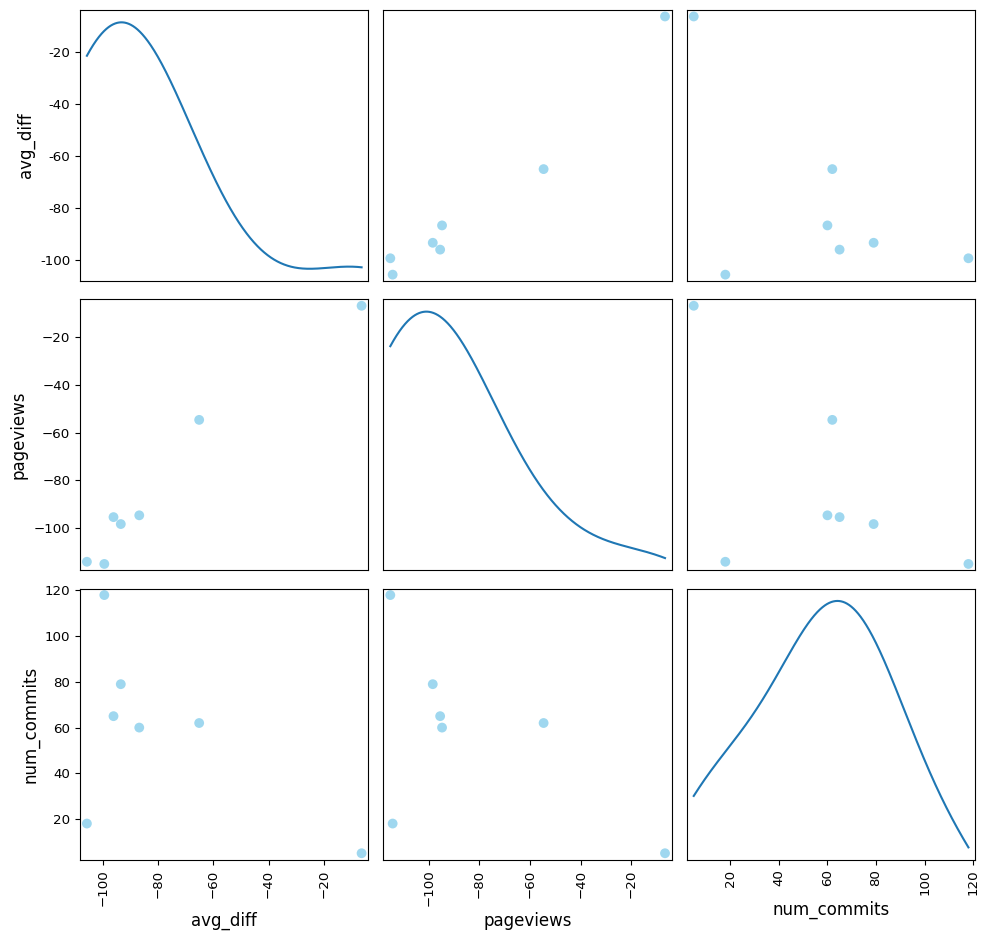

In [13]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

ab_test_path = '../../datasets/data/ab-test.csv'
df_ab_test = pd.read_csv(ab_test_path)

df_ab_test_test_group = df_ab_test[df_ab_test['group'] == 'test'].copy()

df_pageviews_from_csv = df_ab_test_test_group.groupby('uid')['diff'].mean().reset_index()
df_pageviews_from_csv.rename(columns={'uid': 'user_id', 'diff': 'pageviews'}, inplace=True)
test_group_uids = df_pageviews_from_csv['user_id'].unique()

db_path = '../../datasets/data/checking-logs.sqlite'
conn = sqlite3.connect(db_path)

query_avg_diff = '''
    SELECT
        c.uid AS user_id,
        MIN(c.timestamp) AS first_commit_time,
        d.deadlines AS deadline_time,
        c.labname
    FROM
        checker AS c
    JOIN
        deadlines AS d ON c.labname = d.labs
    WHERE
        c.labname != 'project1'
    GROUP BY
        c.uid, c.labname
'''
df_avg_diff_raw = pd.read_sql_query(query_avg_diff, conn)

df_avg_diff_raw['first_commit_time'] = pd.to_datetime(df_avg_diff_raw['first_commit_time'])
df_avg_diff_raw['deadline_time'] = pd.to_datetime(df_avg_diff_raw['deadline_time'], unit='s')

df_avg_diff_raw['diff_hours'] = (df_avg_diff_raw['first_commit_time'] - df_avg_diff_raw['deadline_time']).dt.total_seconds() / 3600

avg_diff_per_user = df_avg_diff_raw.groupby('user_id')['diff_hours'].mean().reset_index()
avg_diff_per_user.rename(columns={'diff_hours': 'deadlines'}, inplace=True)

query_total_commits = '''
    SELECT
        ch.uid AS user_id,
        COUNT(ch.timestamp) AS checker
    FROM
        checker AS ch
    WHERE
        ch.labname != 'project1'
    GROUP BY
        ch.uid
'''
df_total_commits = pd.read_sql_query(query_total_commits, conn)

conn.close()

df_merged = pd.merge(df_pageviews_from_csv, avg_diff_per_user, on='user_id', how='left')
df_merged = pd.merge(df_merged, df_total_commits, on='user_id', how='left')

df_final = df_merged[df_merged['user_id'].isin(test_group_uids)].copy()

df_final.fillna(0, inplace=True)

df_final['checker'] = df_final['checker'].astype(int)

columns_to_plot = ['deadlines', 'pageviews', 'checker']

plot_color = 'skyblue'
plot_fontsize = 12
plot_figsize = (10, 10)

ax = scatter_matrix(
    df_final[columns_to_plot],
    figsize=plot_figsize,
    color=plot_color,
    s=200,
    diagonal='kde',
    linewidths=3,
    alpha=0.8
)

russian_labels = {
    'deadlines': 'avg_diff',
    'pageviews': 'pageviews',
    'checker': 'num_commits'
}

for i in range(len(columns_to_plot)):
    ax[i, 0].set_ylabel(russian_labels[columns_to_plot[i]], fontsize=plot_fontsize)
    ax[-1, i].set_xlabel(russian_labels[columns_to_plot[i]], fontsize=plot_fontsize)
    for j in range(len(columns_to_plot)):
        ax[i, j].tick_params(axis='both', which='major', labelsize=plot_fontsize * 0.8)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

Can we say that if a user has a low number of pageviews then they likely
have a low number of commits?

No

Can we say that if a user has a low number of pageviews then they likely have
a small average difference between the first commit and the lab deadline?

No

Can we say that there are many users with a low number of commits and a
few with a high number of commits?

Yes

Can we say that there are many users with a small average difference and a
few with a large average difference?

Yes